In [2]:
import pandas as pd
import networkx as nx
from datetime import timedelta
from typing import Tuple

In [3]:
WINDOW_DAYS = 14 # ±14 days window relative to positive test date
DATE_FMT = "%Y-%m-%d"

In [4]:
def _read_csv(transfers_path: str, microbiology_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    tf = pd.read_csv(transfers_path, dtype=str)
    mc = pd.read_csv(microbiology_path, dtype=str)

    # Parse dates
    tf['ward_in_time'] = pd.to_datetime(tf['ward_in_time']).dt.normalize()
    tf['ward_out_time'] = pd.to_datetime(tf['ward_out_time']).dt.normalize()
    mc['collection_date'] = pd.to_datetime(mc['collection_date']).dt.normalize()

    # Basic cleaning
    tf = tf.dropna(subset=['patient_id', 'location', 'ward_in_time', 'ward_out_time'])
    mc = mc.dropna(subset=['patient_id', 'infection', 'result', 'collection_date'])

    return tf, mc

In [14]:
tf, mc = _read_csv("sample_data/transfers.csv", "sample_data/microbiology.csv")
mc[mc['result'] == 'positive']

,test_id,patient_id,collection_date,infection,result
8,MR14FFYVN,P0013,2025-04-08,CRE,positive
9,MXKI3OQYF,P0015,2025-06-30,CRE,positive
11,MNVBC2VYH,P0017,2025-04-21,ESBL,positive
15,MZBNZ8V12,P0023,2025-06-11,CRE,positive
22,MUAXEQBNH,P0039,2025-05-17,CRE,positive
...,...,...,...,...,...
355,MTIRZQAKO,P0466,2025-05-20,CRE,positive
370,MPN0P1XS9,P0484,2025-05-09,MRSA,positive
372,MTA3RUNYN,P0488,2025-04-27,MRSA,positive
377,MCJ883DHX,P0493,2025-05-30,CRE,positive


In [5]:
def _compute_positive_index(mc: pd.DataFrame) -> pd.DataFrame:
    # Finds first positive date per (patient_id, infection)
    positives = mc[mc['result'].str.lower() == 'positive'].copy()
    if positives.empty:
        return positives
    earliest = (
        positives.sort_values('collection_date')
        .groupby(['patient_id', 'infection'], as_index=False)
        .first()
    )
    earliest.rename(columns={'collection_date': 'positive_date'}, inplace=True)
    earliest['win_start'] = earliest['positive_date'] - pd.Timedelta(days=WINDOW_DAYS)
    earliest['win_end'] = earliest['positive_date'] + pd.Timedelta(days=WINDOW_DAYS)
    return earliest

In [11]:
pos_idx = _compute_positive_index(mc)
pos_idx

,patient_id,infection,test_id,positive_date,result,win_start,win_end
0,P0013,CRE,MR14FFYVN,2025-04-08,positive,2025-03-25,2025-04-22
1,P0015,CRE,MXKI3OQYF,2025-06-30,positive,2025-06-16,2025-07-14
2,P0017,ESBL,MNVBC2VYH,2025-04-21,positive,2025-04-07,2025-05-05
3,P0023,CRE,MZBNZ8V12,2025-06-11,positive,2025-05-28,2025-06-25
4,P0039,CRE,MUAXEQBNH,2025-05-17,positive,2025-05-03,2025-05-31
...,...,...,...,...,...,...,...
70,P0466,CRE,MTIRZQAKO,2025-05-20,positive,2025-05-06,2025-06-03
71,P0484,MRSA,MPN0P1XS9,2025-05-09,positive,2025-04-25,2025-05-23
72,P0488,MRSA,MTA3RUNYN,2025-04-27,positive,2025-04-13,2025-05-11
73,P0493,CRE,MCJ883DHX,2025-05-30,positive,2025-05-16,2025-06-13


In [6]:
def _expand_transfers_to_days(tf: pd.DataFrame, date_min: pd.Timestamp, date_max: pd.Timestamp) -> pd.DataFrame:
    """
    Expand transfers into per-day presence rows within [date_min, date_max].
    Columns: patient_id, date, location
    """
    tf2 = tf.copy()
    # Clip intervals to the allowed date range
    tf2['start'] = tf2['ward_in_time'].clip(lower=date_min, upper=date_max)
    tf2['end'] = tf2['ward_out_time'].clip(lower=date_min, upper=date_max)
    tf2 = tf2[tf2['end'] >= tf2['start']]

    # Create per-day date ranges and explode into separate rows
    tf2['date_range'] = tf2.apply(lambda r: pd.date_range(r['start'], r['end'], freq='D'), axis=1)
    exploded = tf2[['patient_id', 'location', 'date_range']].explode('date_range').rename(columns={'date_range': 'date'})
    exploded['date'] = exploded['date'].dt.normalize()
    return exploded

In [15]:
date_min = (pos_idx['win_start'].min()).normalize()
date_max = (pos_idx['win_end'].max()).normalize()
presence = _expand_transfers_to_days(tf, date_min, date_max)
presence

,patient_id,location,date
0,P0001,Ward-2,2025-04-03
0,P0001,Ward-2,2025-04-04
0,P0001,Ward-2,2025-04-05
0,P0001,Ward-2,2025-04-06
0,P0001,Ward-2,2025-04-07
...,...,...,...
696,P0500,Ward-5,2025-05-15
696,P0500,Ward-5,2025-05-16
696,P0500,Ward-5,2025-05-17
696,P0500,Ward-5,2025-05-18


In [7]:
def _build_contacts_for_infection(presence: pd.DataFrame, pos_idx: pd.DataFrame, infection: str) -> pd.DataFrame:
    """Return contact edges (u, v, date, location) among positives for a given infection."""
    p = pos_idx[pos_idx['infection'] == infection].copy()
    if p.empty:
        return pd.DataFrame(columns=['u', 'v', 'date', 'location'])

    # Keep only presence rows for patients in this infection and within their window
    pres = presence.merge(p[['patient_id', 'win_start', 'win_end']], on='patient_id', how='inner')
    pres = pres[(pres['date'] >= pres['win_start']) & (pres['date'] <= pres['win_end'])]

    # Self-join on (date, location) to find co-presence pairs
    left = pres.rename(columns={'patient_id': 'u'})
    right = pres.rename(columns={'patient_id': 'v'})
    pairs = left.merge(right, on=['date', 'location'])

    # Remove self-pairs and make undirected unique pairs (u < v lexicographically)
    pairs = pairs[pairs['u'] != pairs['v']]
    pairs['a'] = pairs[['u', 'v']].min(axis=1)
    pairs['b'] = pairs[['u', 'v']].max(axis=1)
    pairs = pairs.drop_duplicates(subset=['a', 'b', 'date', 'location'])

    return pairs[['a', 'b', 'date', 'location']].rename(columns={'a': 'u', 'b': 'v'})

In [16]:
_build_contacts_for_infection(presence, pos_idx, "MRSA")

,u,v,date,location
3,P0121,P0451,2025-06-15,ICU
7,P0121,P0451,2025-06-16,ICU
11,P0121,P0451,2025-06-17,ICU
15,P0121,P0451,2025-06-18,ICU
37,P0290,P0488,2025-04-25,Ward-3
41,P0290,P0488,2025-04-26,Ward-3
50,P0339,P0423,2025-05-08,ICU
54,P0339,P0423,2025-05-09,ICU


In [17]:
clusters_all = []
cluster_counter = 1

for infection in sorted(pos_idx['infection'].unique()):
    print(f"{infection}")
    edges = _build_contacts_for_infection(presence, pos_idx, infection)
    
    # Build Graph
    G = nx.Graph()
    pts = pos_idx[pos_idx['infection'] == infection]['patient_id'].unique().tolist()
    G.add_nodes_from(pts)
    
    # Add Edges
    if not edges.empty:
        w = (
        edges.groupby(['u', 'v']).size().reset_index(name='contact_events')
        )
        for _, row in w.iterrows():
            G.add_edge(row['u'], row['v'], contact_events=int(row['contact_events']))
    
    # Connected component size >= 2 (Infection Cluster)
    for comp in nx.connected_components(G):
        # print(comp)
        if len(comp) < 2:
            continue
        members = sorted(list(comp))
        # print(members)
        sub = G.subgraph(members)
        # Cluster metrics
        pos_sub = pos_idx[(pos_idx['infection'] == infection) & (pos_idx['patient_id'].isin(members))]
        first_pos = pos_sub['positive_date'].min()
        last_pos = pos_sub['positive_date'].max()
        timespan_days = int((last_pos - first_pos).days)
        # print(timespan_days)
        contact_edges = sub.number_of_edges()
        contact_events = int(sum(d.get('contact_events', 0) for _, _, d in sub.edges(data=True)))
        # print(contact_events)
        
        # Locations involved (from edges -> dates/locations)
        locs = set()
        if not edges.empty:
            elocs = edges[(edges['u'].isin(members)) & (edges['v'].isin(members))]
            locs = set(elocs['location'].unique().tolist())
            # print(locs)
        
        clusters_all.append({
            'cluster_id': cluster_counter,
            'infection': infection,
            'size': len(members),
            'members': members,
            'first_positive': first_pos.strftime(DATE_FMT),
            'last_positive': last_pos.strftime(DATE_FMT),
            'timespan_days': timespan_days,
            'locations': sorted(list(locs)),
            'contact_edges': contact_edges,
            'contact_events': contact_events,
        })
        cluster_counter += 1

infections = sorted({c['infection'] for c in clusters_all})
# clusters_all

CRE
ESBL
MRSA
VRE


In [8]:
def detect_clusters(transfers_path: str, microbiology_path: str):
    tf, mc = _read_csv(transfers_path, microbiology_path)
    pos_idx = _compute_positive_index(mc)

    if pos_idx.empty:
        return {
            'clusters': [],
            'stats': {
                'infections': [],
                'total_clusters': 0,
                'patients_positive': 0
            }
        }

    # Limit expansion to relevant time horizon only
    date_min = (pos_idx['win_start'].min()).normalize()
    date_max = (pos_idx['win_end'].max()).normalize()

    presence = _expand_transfers_to_days(tf, date_min, date_max)

    clusters_all = []
    cluster_counter = 1

    for infection in sorted(pos_idx['infection'].unique()):
        edges = _build_contacts_for_infection(presence, pos_idx, infection)

        # Build graph among positive patients for this infection
        G = nx.Graph()
        pts = pos_idx[pos_idx['infection'] == infection]['patient_id'].unique().tolist()
        G.add_nodes_from(pts)

        # Edge weight: number of distinct contact days (or contact events)
        if not edges.empty:
            w = (
            edges.groupby(['u', 'v'])
            .size()
            .reset_index(name='contact_events')
            )
            for _, row in w.iterrows():
                G.add_edge(row['u'], row['v'], contact_events=int(row['contact_events']))

        # Connected components with size >= 2
        for comp in nx.connected_components(G):
            if len(comp) < 2:
                continue
            members = sorted(list(comp))
            sub = G.subgraph(members)
            
            # Metrics
            pos_sub = pos_idx[(pos_idx['infection'] == infection) & (pos_idx['patient_id'].isin(members))]
            first_pos = pos_sub['positive_date'].min()
            last_pos = pos_sub['positive_date'].max()
            timespan_days = int((last_pos - first_pos).days)
            
            # Extract edges with contact events
            edges_list = []
            for u, v, data in sub.edges(data=True):
                edges_list.append({
                    "from": u,
                    "to": v,
                    "contact_events": data.get('contact_events', 0)
                })
                
            contact_edges = sub.number_of_edges()
            contact_events = int(sum(d.get('contact_events', 0) for _, _, d in sub.edges(data=True)))

            # Locations involved (from edges -> dates/locations)
            locs = set()
            if not edges.empty:
                elocs = edges[(edges['u'].isin(members)) & (edges['v'].isin(members))]
                locs = set(elocs['location'].unique().tolist())

            clusters_all.append({
            'cluster_id': cluster_counter,
            'infection': infection,
            'size': len(members),
            'members': members,
            'first_positive': first_pos.strftime(DATE_FMT),
            'last_positive': last_pos.strftime(DATE_FMT),
            'timespan_days': timespan_days,
            'locations': sorted(list(locs)),
            'contact_edges': contact_edges,
            'contact_events': contact_events,
            'edges_list': edges_list
            })
            cluster_counter += 1
    
    grouped = {}
    for c in clusters_all:
        grouped.setdefault(c['infection'], []).append(c)
    infections = sorted({c['infection'] for c in clusters_all})
    return {
        "clusters": grouped,
        "stats": {
            'infections': infections,
            'total_clusters': len(clusters_all),
            'patients_positive': int(pos_idx['patient_id'].nunique())
        }
    }
    # infections = sorted({c['infection'] for c in clusters_all})
    # return {
    #     'clusters': clusters_all,
    #     'stats': {
    #         'infections': infections,
    #         'total_clusters': len(clusters_all),
    #         'patients_positive': int(pos_idx['patient_id'].nunique())
    #     }
    # }

In [21]:
clusters = detect_clusters("sample_data/transfers.csv", "sample_data/microbiology.csv")
# clusters

In [22]:
def build_ward_summary(clusters_by_infection: dict):
    ward_summary = {}
    for infection, groups in clusters_by_infection.items():
        for cluster in groups:
            for loc in cluster["locations"]:
                ward_summary.setdefault(loc, {}).setdefault(infection, 0)
                ward_summary[loc][infection] += cluster["size"]
    return ward_summary

In [24]:
build_ward_summary(clusters["clusters"])

{'Ward-2': {'CRE': 11},
 'Ward-3': {'CRE': 15, 'MRSA': 2},
 'ICU': {'CRE': 8, 'MRSA': 4},
 'Ward-6': {'CRE': 8},
 'Ward-5': {'CRE': 11},
 'Ward-7': {'CRE': 10}}

In [2]:
movements_df = pd.read_csv("transfers.csv")
tests_df = pd.read_csv("microbiology.csv")

,transfer_id,patient_id,ward_in_time,ward_out_time,location
0,T9V20YAR8,P0001,2025-04-03,2025-04-09,Ward-2
1,TSBELRQVS,P0001,2025-04-19,2025-04-23,Ward-7
2,T1N3IUZGP,P0002,2025-04-07,2025-04-15,Surgical-Theatre
3,TYN9382KK,P0003,2025-05-15,2025-05-20,Surgical-Theatre
4,TQTTY5Y2J,P0003,2025-06-01,2025-06-08,Ward-3


In [3]:
tests_df.head()

,test_id,patient_id,collection_date,infection,result
0,MWF90KM3T,P0001,2025-04-21,CRE,negative
1,MOHSWQ40Z,P0002,2025-04-10,CRE,negative
2,M8KK791ZY,P0003,2025-06-04,CRE,negative
3,MIDLRYE89,P0004,2025-05-05,CRE,negative
4,MUFLSEHUD,P0010,2025-05-01,CRE,negative


In [4]:
movements_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transfer_id    697 non-null    object
 1   patient_id     697 non-null    object
 2   ward_in_time   697 non-null    object
 3   ward_out_time  697 non-null    object
 4   location       697 non-null    object
dtypes: object(5)
memory usage: 27.4+ KB


In [5]:
tests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   test_id          384 non-null    object
 1   patient_id       384 non-null    object
 2   collection_date  384 non-null    object
 3   infection        384 non-null    object
 4   result           384 non-null    object
dtypes: object(5)
memory usage: 15.1+ KB


In [6]:
tests_df.describe()

,test_id,patient_id,collection_date,infection,result
count,384,384,384,384,384
unique,384,298,91,4,2
top,MWF90KM3T,P0475,2025-05-17,CRE,negative
freq,1,3,10,328,309


In [7]:
df = pd.merge(movements_df, tests_df, on='patient_id', how='left')
df['ward_in_time'] = pd.to_datetime(df['ward_in_time'])
df['ward_out_time'] = pd.to_datetime(df['ward_out_time'])
df['collection_date'] = pd.to_datetime(df['collection_date'])
df.head()

,transfer_id,patient_id,ward_in_time,ward_out_time,location,test_id,collection_date,infection,result
0,T9V20YAR8,P0001,2025-04-03,2025-04-09,Ward-2,MWF90KM3T,2025-04-21,CRE,negative
1,TSBELRQVS,P0001,2025-04-19,2025-04-23,Ward-7,MWF90KM3T,2025-04-21,CRE,negative
2,T1N3IUZGP,P0002,2025-04-07,2025-04-15,Surgical-Theatre,MOHSWQ40Z,2025-04-10,CRE,negative
3,TYN9382KK,P0003,2025-05-15,2025-05-20,Surgical-Theatre,M8KK791ZY,2025-06-04,CRE,negative
4,TQTTY5Y2J,P0003,2025-06-01,2025-06-08,Ward-3,M8KK791ZY,2025-06-04,CRE,negative


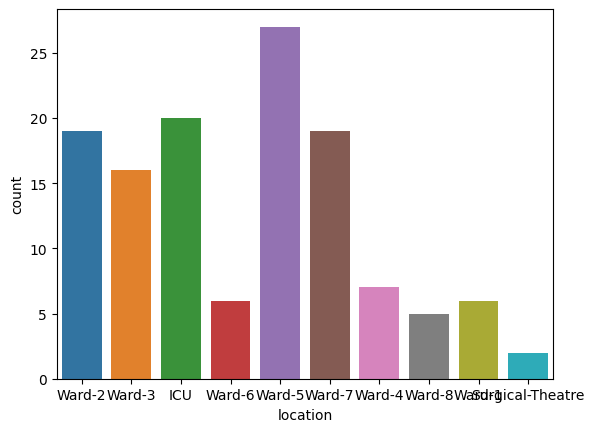

In [8]:
# Positive cases per ward
sns.countplot(data=df[df['result'] == 'positive'], x='location')
plt.show()

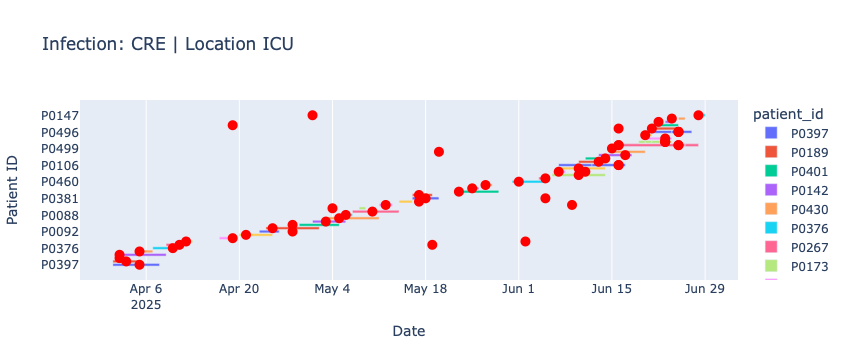

In [13]:
import plotly.express as px
import plotly.graph_objects as go

def plot_patient_stays_with_tests(df, infection, location):
    # Filter
    filtered = df[(df['infection'] == infection) & (df['location'] == location)].copy()
    filtered.sort_values("ward_in_time", inplace=True)
    
    # Create GANTT bars
    fig = px.timeline(
    filtered,
    x_start="ward_in_time",
    x_end="ward_out_time",
    y="patient_id",
    color="patient_id",
    title=f"Infection: {infection} | Location {location}",
    )
    
    fig.update_yaxes(autorange="reversed") # earliest patient first
    
    # Add dots for test collection dates
    for _, row in filtered.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['collection_date']],
            y=[row['patient_id']],
            mode='markers',
            marker=dict(color='red', size=10),
            name='Positive Test',
            showlegend=False,
        ))
        
    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Patient ID",
        height=400 + 40 * len(filtered),
    )
    
    fig.show()

plot_patient_stays_with_tests(df, infection="CRE", location="ICU")

In [14]:
def detect_clusters(transfers_df, micro_df):
    # Convert dates
    transfers_df['ward_in_time'] = pd.to_datetime(transfers_df['ward_in_time'])
    transfers_df['ward_out_time'] = pd.to_datetime(transfers_df['ward_out_time'])
    micro_df['collection_date'] = pd.to_datetime(micro_df['collection_date'])
    
    # Filter positive results
    micro_df = micro_df[micro_df['result'] == 'positive']
    
    # Merge microbiology and transfers
    merged = pd.merge(transfers_df, micro_df, on='patient_id')
    
    # Only consider infections that happened during or after admission
    merged = merged[merged['collection_date'] >= merged['ward_in_time']]
    
    clusters = []
    infections = merged['infection'].unique()
    
    for infection in infections:
        subset = merged[merged['infection'] == infection]
        for i, row1 in subset.iterrows():
            for j, row2 in subset.iterrows():
                if i >= j:
                    continue # Avoid duplicate pairs
                # Check location
                if row1['location'] != row2['location']:
                    continue
                # Check time overlap
                latest_start = max(row1['ward_in_time'], row2['ward_in_time'])
                earliest_end = max(row1['ward_out_time'], row2['ward_out_time'])
                if (latest_start <= earliest_end):
                    clusters.append({
                        'infection': infection,
                        'patient_1': row1['patient_id'],
                        'patient_2': row2['patient_id'],
                        'location': row1['location'],
                        'overlap_start': latest_start,
                        'overlap_end': earliest_end
                    })
    
    return clusters
    
    

In [15]:
cluster_df = pd.DataFrame(detect_clusters(movements_df, tests_df))
cluster_df

,infection,patient_1,patient_2,location,overlap_start,overlap_end
0,CRE,P0013,P0115,Ward-2,2025-04-13,2025-04-16
1,CRE,P0013,P0126,Ward-2,2025-04-11,2025-04-17
2,CRE,P0013,P0141,Ward-2,2025-04-06,2025-04-13
3,CRE,P0013,P0204,Ward-2,2025-05-02,2025-05-06
4,CRE,P0013,P0328,Ward-2,2025-04-03,2025-04-14
...,...,...,...,...,...,...
498,MRSA,P0339,P0423,ICU,2025-05-08,2025-05-14
499,MRSA,P0339,P0451,ICU,2025-06-15,2025-06-20
500,MRSA,P0423,P0451,ICU,2025-06-15,2025-06-20
501,MRSA,P0445,P0488,Ward-3,2025-06-16,2025-06-21


In [23]:
import networkx as nx

def detect_clusters(df):
    # Must include: patient_id, infection, ward_in_time, ward_out_time, location
    clusters=[]
    G = nx.Graph()
    
    # Ensure datetime
    df['ward_in_time'] = pd.to_datetime(df['ward_in_time'])
    df['ward_out_time'] = pd.to_datetime(df['ward_out_time'])
    
    for infection in df['infection'].unique():
        sub_inf = df[df['infection'] == infection]
        
        for location in sub_inf['location'].unique():
            sub_loc = sub_inf[sub_inf['location'] == location]
            
            # Compare all pairs
            for i, row1 in sub_loc.iterrows():
                for j, row2 in sub_loc.iterrows():
                    if i >= j:
                        continue
                    
                    # Time overlap
                    latest_start = max(row1['ward_in_time'], row2['ward_in_time'])
                    earliest_end = min(row1['ward_out_time'], row2['ward_out_time'])
                    
                    if latest_start <= earliest_end:
                        # Add edge to graph
                        G.add_node(row1['patient_id'], infection=row1['infection'], location=row1['location'])
                        G.add_node(row2['patient_id'], infection=row2['infection'], location=row2['location'])
                        G.add_edge(row1['patient_id'], row2['patient_id'])
            
    # Extract connected components (clusters)
    cluster_id = 0
    for component in nx.connected_components(G):
        cluster_patients = list(component)
        # print(f"{cluster_patients}")
        cluster_subdf = df[df['patient_id'].isin(cluster_patients)].copy()
        cluster_subdf['cluster_id'] = f"cluster_{cluster_id}"
        clusters.append(cluster_subdf)
        cluster_id += 1
    
    return pd.concat(clusters, ignore_index=True) if clusters else pd.DataFrame()
        

In [22]:
detect_clusters(df)

['P0270', 'P0178', 'P0309', 'P0233', 'P0194', 'P0490', 'P0386', 'P0381', 'P0111', 'P0139', 'P0451', 'P0036', 'P0316', 'P0226', 'P0313', 'P0028', 'P0439', 'P0462', 'P0223', 'P0133', 'P0249', 'P0106', 'P0498', 'P0193', 'P0151', 'P0259', 'P0109', 'P0152', 'P0167', 'P0405', 'P0137', 'P0456', 'P0493', 'P0308', 'P0366', 'P0369', 'P0497', 'P0094', 'P0488', 'P0482', 'P0453', 'P0285', 'P0395', 'P0168', 'P0040', 'P0406', 'P0466', 'P0416', 'P0484', 'P0455', 'P0264', 'P0095', 'P0347', 'P0081', 'P0076', 'P0321', 'P0175', 'P0086', 'P0004', 'P0346', 'P0047', 'P0244', 'P0283', 'P0135', 'P0115', 'P0184', 'P0059', 'P0423', 'P0434', 'P0049', 'P0481', 'P0315', 'P0252', 'P0480', 'P0170', 'P0499', 'P0018', 'P0234', 'P0220', 'P0205', 'P0402', 'P0354', 'P0362', 'P0428', 'P0279', 'P0380', 'P0388', 'P0255', 'P0408', 'P0489', 'P0412', 'P0370', 'P0037', 'P0101', 'P0350', 'P0232', 'P0104', 'P0407', 'P0383', 'P0011', 'P0107', 'P0328', 'P0250', 'P0292', 'P0216', 'P0318', 'P0001', 'P0204', 'P0200', 'P0211', 'P0431', 

""


In [17]:
import plotly.express as px
import plotly.graph_objects as go

def plot_cluster_timeline(cluster_df):
    infection = cluster_df['infection'].iloc[0]
    location = cluster_df['location'].iloc[0]
    cluster_id = cluster_df['cluster_id'].iloc[0]

    cluster_df = cluster_df.sort_values("ward_in_time")

    fig = px.timeline(
        cluster_df,
        x_start="ward_in_time",
        x_end="ward_out_time",
        y="patient_id",
        color="patient_id",
        title=f"{infection} | {location} | {cluster_id}",
    )

    fig.update_yaxes(autorange="reversed")

    # Add collection_date dots
    for _, row in cluster_df.iterrows():
        fig.add_trace(go.Scatter(
            x=[row['collection_date']],
            y=[row['patient_id']],
            mode='markers',
            marker=dict(color='red', size=10),
            name='Positive Test',
            showlegend=False
        ))

    fig.update_layout(
        xaxis_title="Date",
        yaxis_title="Patient",
        height=400 + 40 * len(cluster_df),
    )

    fig.show()

In [21]:
clustered_df = detect_clusters(df)

# Loop through each cluster and plot
for cluster_id in clustered_df['cluster_id'].unique():
    cluster = clustered_df[clustered_df['cluster_id'] == cluster_id]
    plot_cluster_timeline(cluster)

['P0270', 'P0178', 'P0309', 'P0233', 'P0194', 'P0490', 'P0386', 'P0381', 'P0111', 'P0139', 'P0451', 'P0036', 'P0316', 'P0226', 'P0313', 'P0028', 'P0439', 'P0462', 'P0223', 'P0133', 'P0249', 'P0106', 'P0498', 'P0193', 'P0151', 'P0259', 'P0109', 'P0152', 'P0167', 'P0405', 'P0137', 'P0456', 'P0493', 'P0308', 'P0366', 'P0369', 'P0497', 'P0094', 'P0488', 'P0482', 'P0453', 'P0285', 'P0395', 'P0168', 'P0040', 'P0406', 'P0466', 'P0416', 'P0484', 'P0455', 'P0264', 'P0095', 'P0347', 'P0081', 'P0076', 'P0321', 'P0175', 'P0086', 'P0004', 'P0346', 'P0047', 'P0244', 'P0283', 'P0135', 'P0115', 'P0184', 'P0059', 'P0423', 'P0434', 'P0049', 'P0481', 'P0315', 'P0252', 'P0480', 'P0170', 'P0499', 'P0018', 'P0234', 'P0220', 'P0205', 'P0402', 'P0354', 'P0362', 'P0428', 'P0279', 'P0380', 'P0388', 'P0255', 'P0408', 'P0489', 'P0412', 'P0370', 'P0037', 'P0101', 'P0350', 'P0232', 'P0104', 'P0407', 'P0383', 'P0011', 'P0107', 'P0328', 'P0250', 'P0292', 'P0216', 'P0318', 'P0001', 'P0204', 'P0200', 'P0211', 'P0431', 

KeyError: 'cluster_id'